In [1]:
import numpy as np
import torch as th
from matplotlib import pyplot as plt
import qepsilon as qe
from qepsilon.simulation.mixed_unitary_system import OscillatorTightBindingUnitarySystem
from qepsilon.simulation.lindblad_system import LindbladSystem
from qepsilon.operator_group.tb_operators import PeriodicNoiseTightBindingOperatorGroup, StaticTightBindingOperatorGroup
from qepsilon.utilities import Constants_Metal as Constants
import os

dev = 'cuda' if th.cuda.is_available() else 'cpu'
th.set_printoptions(sci_mode=False, precision=5)
np.set_printoptions(suppress=True, precision=5)


In [2]:
"""
Preprocessing
"""
nsites= 150
temperature = 300
hopping_in_meV = 83  # in meV
timestep_in_fs = 0.05   # in fs
batchsize = 1
sim_time = 200   # in fs

## make output folder
out_folder = 'T{:.0f}_ns{}'.format(temperature, nsites)
os.makedirs(out_folder, exist_ok=True)

## load DIQCD model parameters
data_folder = '../01.train_DIQCD/T{:.0f}_dt{:.3f}fs'.format(temperature, 0.05)
tau_list = np.loadtxt(os.path.join(data_folder, 'tau_list.txt'))[-1] 
amp_list = np.loadtxt(os.path.join(data_folder, 'amp_list.txt'))[-1] 
dephasing = np.loadtxt(os.path.join(data_folder, 'dephasing_list.txt'))[-1] 

print('mode period:', tau_list)
print('mode amplitude:', amp_list)
                       
## process system parameters
ns = nsites
nmodes = tau_list.shape[0]
hopping_coef = hopping_in_meV * Constants.meV
total_t = sim_time * Constants.fs
dt = timestep_in_fs * Constants.fs
nsteps =  int(total_t / dt)


mode period: [397.1 155.8  52.8  33.3  27.7  24.7  24.5  21.7  20.9]
mode amplitude: [ 18.43   2.83   0.84   1.13   1.76   4.15   1.39 100.14   2.73]


In [3]:
"""
Define the system
"""
simulation = LindbladSystem(num_states=ns, batchsize=batchsize)

## set initial state
init_site = ns//2
init_state = th.zeros(ns, ns, dtype=th.cfloat)
init_state[init_site, init_site] = 1
simulation.rho = init_state.clone()

## add hopping terms
op_hop = StaticTightBindingOperatorGroup(n_sites=ns, id="hop", batchsize=batchsize, coef=hopping_coef, static=True, requires_grad=False)
for idx in range(ns):
    hop_seq_1 = ['X'] * ns 
    hop_seq_1[idx] = 'L'
    hop_seq_1 = "".join(hop_seq_1)
    op_hop.add_operator(hop_seq_1)

    hop_seq_2 = ['X'] * ns 
    hop_seq_2[idx] = 'R'
    hop_seq_2 = "".join(hop_seq_2)
    op_hop.add_operator(hop_seq_2)
simulation.add_operator_group_to_hamiltonian(op_hop)

## add classical harmonic oscillators
for isite in range(ns):
    for imode in range(nmodes):
        opg_epc = PeriodicNoiseTightBindingOperatorGroup(
            n_sites=ns, id=f"site-{isite}_mode-{imode}_epc", batchsize=batchsize,tau=tau_list[imode], amp=amp_list[imode], requires_grad=False)
        epc_seq = ['X'] * ns 
        epc_seq[isite] = 'N'
        opg_epc.add_operator("".join(epc_seq))
        simulation.add_operator_group_to_hamiltonian(opg_epc)

## add jump operators
for isite in range(ns):
    opg_dephasing = StaticTightBindingOperatorGroup(n_sites=ns, id=f"site-{isite}_dephasing", batchsize=batchsize, coef=dephasing, static=False, requires_grad=False)
    dephasing_seq = ['X'] * ns 
    dephasing_seq[isite] = 'N'
    opg_dephasing.add_operator("".join(dephasing_seq))
    simulation.add_operator_group_to_jumping(opg_dephasing)

## move to GPU if dev='cuda'
simulation.to(dev)

In [4]:
"""
Simulate DIQCD
"""
t_traj = []
site_occupation_traj = []
MSD_traj = []
for step in range(nsteps):
    if step % int(1 / timestep_in_fs) == 0:
        print('======== Step-{}, t={:.0f}fs========'.format(step, step * dt/Constants.fs))
        t_traj.append(step * dt/Constants.fs)
        simulation.normalize()
        density_matrix = simulation.rho
        ## get diagonal elements
        site_occupation = density_matrix.diagonal(dim1=1, dim2=2)  # (batchsize, ns)
        site_occupation = site_occupation.real
        assert site_occupation.shape == (batchsize, ns)
        assert site_occupation.sum(dim=-1).allclose(th.ones(batchsize, device=site_occupation.device))
        site_occupation_traj.append(site_occupation)

        pos =  th.arange(ns).to(dtype=site_occupation.dtype, device=site_occupation.device)
        average_r = (site_occupation * pos[None, :]).sum(dim=-1)
        average_r2 = (site_occupation * pos[None, :]**2).sum(dim=-1)
        MSD = average_r2 - average_r**2
        MSD_traj.append(MSD)
        print('Average MSD={}'.format(MSD.mean()))

    simulation.step(dt, profile=False)

======== Step-0, t=0fs========
Average MSD=0.0
======== Step-20, t=1fs========
Average MSD=0.03076171875
======== Step-40, t=2fs========
Average MSD=0.1220703125
======== Step-60, t=3fs========
Average MSD=0.26611328125
======== Step-80, t=4fs========
Average MSD=0.46142578125
======== Step-100, t=5fs========
Average MSD=0.70166015625
======== Step-120, t=6fs========
Average MSD=0.98388671875
======== Step-140, t=7fs========
Average MSD=1.298828125
======== Step-160, t=8fs========
Average MSD=1.642578125
======== Step-180, t=9fs========
Average MSD=2.01220703125
======== Step-200, t=10fs========
Average MSD=2.404296875
======== Step-220, t=11fs========
Average MSD=2.81640625
======== Step-240, t=12fs========
Average MSD=3.24072265625
======== Step-260, t=13fs========
Average MSD=3.6787109375
======== Step-280, t=14fs========
Average MSD=4.13427734375
======== Step-300, t=15fs========
Average MSD=4.59716796875
======== Step-320, t=16fs========
Average MSD=5.0751953125
======== Step-340,

In [5]:
"""
Postprocess
"""
nsample = len(t_traj)

## process the site occupation trajectories
site_occupation_traj = th.stack(site_occupation_traj, dim=0).cpu().numpy()  # (nsample, batchsize, ns)
assert site_occupation_traj.shape[1:] == (batchsize, ns)

## process the MSD trajectory
MSD_traj = th.stack(MSD_traj, dim=0).cpu().numpy()  # (nsample, batchsize)
assert MSD_traj.shape == (nsample, batchsize)
np.save('{}/site_occupation_traj.npy'.format(out_folder), site_occupation_traj)
np.save('{}/MSD_traj.npy'.format(out_folder), MSD_traj)
 

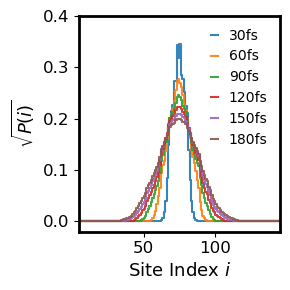

In [159]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 1.5

x = site_occupation_traj[:,0,:] ** 0.5
x = x - x.min()
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.step(np.arange(ns), x[30], alpha=0.9, label='30fs')
ax.step(np.arange(ns),x[60], alpha=0.9, label='60fs')
ax.step(np.arange(ns),x[90], alpha=0.9, label='90fs')
ax.step(np.arange(ns),x[120], alpha=0.9, label='120fs')
ax.step(np.arange(ns),x[150], alpha=0.9, label='150fs')
ax.step(np.arange(ns),x[180], alpha=0.9, label='180fs')
ax.set_xlabel(r'Site Index $n$', fontsize=13)
ax.set_ylabel(r'$\sqrt{P(n)}$', fontsize=13)
ax.set_ylim(-0.02, 0.4)
ax.set_xlim(5, 145)

ax.legend(frameon=False, handlelength=0.5,)
plt.tight_layout()
plt.savefig('site_occupation.png', dpi=200)
plt.show()
plt.close()